<a href="https://colab.research.google.com/github/Samauraiex123/mushroom-classification-project/blob/main/Ethan_and_Eric_Data_Preprocessing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================================
# Clean → Encode → Classify (KNN) — Simplified
# ===============================================
# Dataset: Kaggle "Mushroom Classification"
# Expected file: ./mushrooms.csv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer  # used ONCE as an example
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# =========== From Kaggle =============
import kagglehub
# The dataset download returns a directory. We need the path to the CSV file inside.
dataset_dir = kagglehub.dataset_download("uciml/mushroom-classification")
csv_path = os.path.join(dataset_dir, 'mushrooms.csv')

100%|██████████| 34.2k/34.2k [00:00<00:00, 14.2MB/s]

Extracting files...


In [ ]:
# -----------------------------
# 0) Load data
# -----------------------------
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path} — download from Kaggle and try again.")

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
# TODO: Get the top 5 rows (1 line of code)
display(df.head())

Initial shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
# ----------------
# 0.5) Inspect data
# ----------------
df.info()
print(df.shape)
print(df.columns)
print("--- Columns ------")
for col in df.columns:
  print(col, df[col].unique())
print("--- End of columns list ------")
print("Missing values")
df.isnull().sum()
print("--------------")
df.describe(include='all')
df.duplicated().sum()
print("? count")
df.replace('?', np.nan, inplace = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [ ]:
# -----------------------------
# 1) Basic cleaning (duplicates, empty rows)
# -----------------------------
before = df.shape[0]

# TODO: Remove duplicates (1 line of code)
df = df.drop_duplicates();
print("Removed duplicates:", before - df.shape[0])

before = df.shape[0]
# TODO: Drop fully empty rows (1 line of code)
df.dropna(how = 'all', inplace=True)
print("Dropped fully empty rows:", before - df.shape[0])

print("\nMissing values per column (top 10):")
# TODO: Display the missing values per column (1 line of code)
df.isnull().sum().head(10)

Removed duplicates: 0
Dropped fully empty rows: 0

Missing values per column (top 10):


,0
class,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0


In [ ]:
# -----------------------------
# 2) Target & split
# -----------------------------
TARGET_COL = "class"  # TODO: change if your label column differs
if TARGET_COL not in df.columns:
    raise ValueError("Update TARGET_COL to match your dataset's label column.")

# TODO: Drop the target column from the "X" (1 line of code)
X = df.drop(columns=[TARGET_COL])
# TODO: Set up the target column (1 line of code)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# Detect types BEFORE imputation/encoding
orig_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist() # TODO: Extract the numeric columns from the training data set and store it as a list
orig_categorical_cols = X_train.select_dtypes(include='object').columns.tolist() # TODO: Extract the categorical columns from the training data set and store it as a list
print("Original numeric cols:", orig_numeric_cols if orig_numeric_cols else "None")
print("Original categorical cols (sample):", orig_categorical_cols[:10])


Train/Test shapes: (6499, 22) (1625, 22)
Original numeric cols: None
Original categorical cols (sample): ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape']


In [ ]:
# --------------------------------------------
# 3) IMPUTATION (MANUAL) + one sklearn example
# --------------------------------------------
# Manual imputation rules:
#  - Numeric: fill with TRAIN median
#  - Categorical: fill with TRAIN mode
# NOTE: We compute imputation values on TRAIN only, then apply to both TRAIN & TEST.

X_train_imp = X_train.copy()
X_test_imp  = X_test.copy()

# a) Numeric → manual median
# TODO: For each of the columns, fill the empty values with the median of the column (4 lines of code)
# TODO: Do this for the training and test data separately.
for col in [c for c in orig_numeric_cols if c in X_train_imp.columns]:
    med = X_train_imp[col].median()
    X_train_imp[col] = X_train_imp[col].fillna(med)
    X_test_imp[col]  = X_test_imp[col].fillna(med)

# b) Categorical → manual mode
# TODO: For each of the columns, fill the empty values with the median of the column (4-5 lines of code)
# TODO: Do this for the training and test data separately.
# COMMENT: Fit imputation ONLY on TRAIN to prevent target leakage.
for col in [c for c in orig_categorical_cols if c in X_train_imp.columns]:
    mode = X_train_imp[col].mode()[0]
    X_train_imp[col] = X_train_imp[col].fillna(mode)
    X_test_imp[col]  = X_test_imp[col].fillna(mode)


# c) One EXAMPLE using sklearn SimpleImputer on a SINGLE column (categorical)
# Choose a categorical column present in your dataset:
IMPUTE_EXAMPLE_COL = "odor"  # TODO: change if needed

if IMPUTE_EXAMPLE_COL in X_train_imp.columns:
    cat_imp = SimpleImputer(strategy="most_frequent")

    # .ravel() is used because SimpleImputer returns a 2D NumPy array, (even for a single column), and we need a 1D array to assign back to a single DataFrame column.
    X_train_imp[IMPUTE_EXAMPLE_COL] = cat_imp.fit_transform(X_train_imp[[IMPUTE_EXAMPLE_COL]]).ravel()
    X_test_imp[IMPUTE_EXAMPLE_COL]  = cat_imp.transform(X_test_imp[[IMPUTE_EXAMPLE_COL]]).ravel()
    print(f"\nUsed sklearn SimpleImputer on column: {IMPUTE_EXAMPLE_COL}")
else:
    print(f"\n[Note] Example imputer column '{IMPUTE_EXAMPLE_COL}' not found. Skipping sklearn example.")



Used sklearn SimpleImputer on column: odor


In [ ]:
# --------------------------------------------
# 4) ENCODING
#    - EXPLICIT One-Hot Encoding on ONE chosen column
#    - Then get_dummies for the remaining categoricals
# --------------------------------------------
# Choose the column for explicit OHE:
EXPLICIT_OHE_COL = "odor"  # TODO: change if needed

X_train_enc = X_train_imp.copy()
X_test_enc  = X_test_imp.copy()

# Added explicit OHE for the chosen column and aligned test set
if EXPLICIT_OHE_COL in X_train_enc.columns:
    # EXPLICIT OHE on this ONE column — fit on TRAIN only and TEST only separately (2 lines of code)
    train_ohe = pd.get_dummies(X_train_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)
    test_ohe = pd.get_dummies(X_test_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)

    # Align test columns to train (avoid unseen-category issues)
    test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

    # Drop original column and concat OHE columns
    X_train_enc = pd.concat([X_train_enc.drop(columns=[EXPLICIT_OHE_COL]), train_ohe], axis=1)
    X_test_enc  = pd.concat([X_test_enc.drop(columns=[EXPLICIT_OHE_COL]),  test_ohe], axis=1)

    print(f"\nExplicit OHE applied to column: {EXPLICIT_OHE_COL}")
else:
    print(f"\n[Note] Explicit OHE column '{EXPLICIT_OHE_COL}' not found. Skipping explicit OHE step.")

# TODO: Identify remaining categorical columns (post explicit OHE drop) in the TRAINING data set only (1 line of code)
# Find which columns still contain text categories after removing the one we explicitly encoded.
remaining_cat_cols = X_train_enc.select_dtypes(include=['object', 'category']).columns.tolist()

# TODO: Apply get_dummies to the remaining categoricals (fit on TRAIN, align TEST) (1 lines of code)
# Turn those remaining categorical columns into dummy (0/1) columns for both train and test sets.
# This step helps the model read them as numbers instead of text.
X_train_enc = pd.get_dummies(X_train_enc, columns=remaining_cat_cols); X_test_enc = pd.get_dummies(X_test_enc, columns=remaining_cat_cols)


# Align test columns to train columns (VERY IMPORTANT)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)


Explicit OHE applied to column: odor
Encoded train shape: (6499, 116)
Encoded test shape: (1625, 116)


In [ ]:
# --------------------------------------------
# 5) NORMALIZE numeric columns (if any)
#    (Scale ONLY the original numeric columns; don't scale one-hot columns)
# --------------------------------------------

# Use StandardScaler to make numeric features comparable —
# it shifts each numeric column to have mean = 0 and standard deviation = 1.
scaler = StandardScaler()

# Keep only the numeric columns that actually exist in the encoded training set
# (some may have been dropped or transformed earlier).
numeric_cols_to_scale = [c for c in orig_numeric_cols if c in X_train_enc.columns]

# Fit the scaler on the training data's numeric columns only (to avoid data leakage),
# then transform both training and testing sets so they have the same scale.
if numeric_cols_to_scale:
    scaler.fit(X_train_enc[numeric_cols_to_scale]);
    X_train_enc[numeric_cols_to_scale], X_test_enc[numeric_cols_to_scale] = scaler.transform(X_train_enc[numeric_cols_to_scale]), scaler.transform(X_test_enc[numeric_cols_to_scale])

# Print which columns were actually scaled, or note if none were found.
if numeric_cols_to_scale:
    print("Scaled numeric columns:", numeric_cols_to_scale)
else:
    print("No numeric columns found to scale.")

No numeric columns found to scale.


In [ ]:
# --------------------------------------------
# 6) KNN + Grid Search
# --------------------------------------------
# TODO: Use the KNN Classifier to classify the data

# Use KNN Classifier with GridSearchCV to find the best combination of parameters
knn = KNeighborsClassifier()

# TODO: Test for number of neighbors in the set [3, 5, 7, 9, 11, 15, 21]
# TODO: Try both the types of weights
# TODO: Also try Manhattan and Euclidean distances.

# Define the parameter grid to test different neighbor counts, weight types, and distance metrics
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Use GridSearchCV to test all parameter combinations with 5-fold cross-validation
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# TODO: Fit the grid search on the training data (1 line of code)
grid.fit(X_train_enc, y_train)

# Find and print the best_estimator and print the best parameters

# Print the best model and its parameters
print("Best KNN Model:", grid.best_estimator_)
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Roughly 7 - 9 lines of code including printing the

Best KNN Model: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Accuracy: 1.0



Test accuracy: 1.0000

Classification report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



<Figure size 640x480 with 0 Axes>

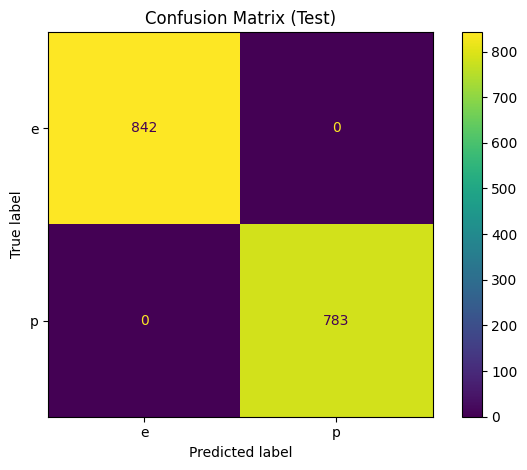

In [ ]:
# --------------------------------------------
# 7) Evaluate on held-out TEST
# --------------------------------------------
# TODO: Use KNN to make predictions on the test dataset (1 line of code)
y_pred = grid.best_estimator_.predict(X_test_enc)


test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy: {:.4f}".format(test_acc))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

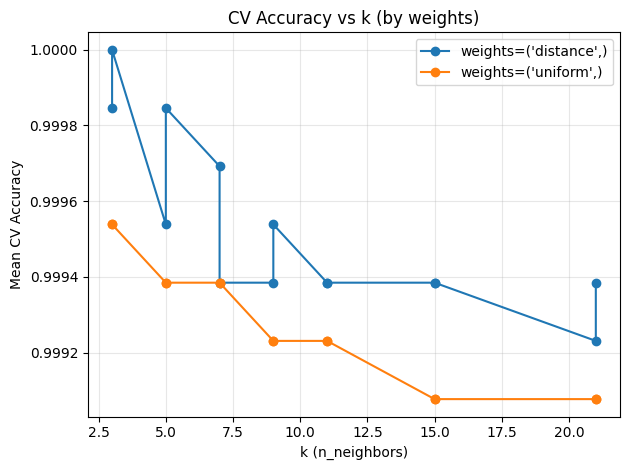

In [ ]:
# --------------------------------------------
# 8) Validation curve (CV accuracy vs k)
# --------------------------------------------
cvres = pd.DataFrame(grid.cv_results_)
plotdf = cvres[["param_n_neighbors", "param_weights", "mean_test_score"]].rename(
    columns={"param_n_neighbors":"k", "param_weights":"weights"}
)

plt.figure()
for (w), sub in plotdf.groupby(["weights"]):
    sub = sub.sort_values("k")
    plt.plot(sub["k"], sub["mean_test_score"], marker="o", label=f"weights={w}")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("CV Accuracy vs k (by weights)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

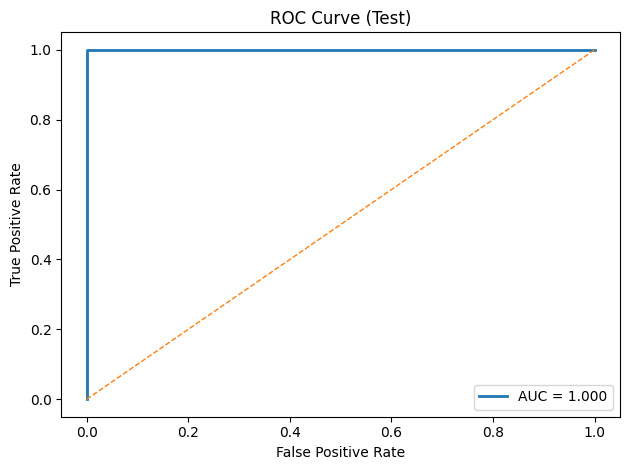

In [ ]:
# --------------------------------------------
# 9) ROC curve (binary; micro-average if multiclass)
# --------------------------------------------
# change the name form best.knn to grid.best_estimator_
if hasattr(grid.best_estimator_, "predict_proba"):
    classes_ = np.unique(y_train)
    y_test_enc_int = pd.Categorical(y_test, categories=classes_).codes
    proba = grid.best_estimator_.predict_proba(X_test_enc)

    if len(classes_) == 2:
        fpr, tpr, _ = roc_curve(y_test_enc_int, proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Test)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    else:
        y_bin = label_binarize(y_test_enc_int, classes=range(len(classes_)))
        fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"Micro-average AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Micro-average)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

In [ ]:
# --------------------------------------------
# 10) Print summary of features
# Sample Output: Final feature count: 25
# Best KNN: KNeighborsClassifier(n_neighbors=7, p=2, weights='distance')
# --------------------------------------------
# TODO: Print the final stats (2 lines of code)


# Print how many features the final training dataset has and show the best KNN model from GridSearch
print(f"Final feature count: {X_train_enc.shape[1]}")
print(f"Best KNN: {grid.best_estimator_}")

Final feature count: 116
Best KNN: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
